# Normal Modes: Ion Chain
Here we estimate normal modes of ion chains and ion pancakes using classical estimations

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import minimize

The energy potential for N identical ions in a linear Paul trap can be estimated as identical masses connected in a 3D harmonic potential. Each ion interacts through it's positive electric charge.

$$
V(x,y) = \sum_{i=1}^{N}\left(\frac{1}{2}m \omega_x^2 x_i^2 + \frac{1}{2}m \omega_y^2 y_i^2 + \frac{1}{2}m \omega_z^2 z_i^2\right) + \sum_{i<j}^{N}\frac{e^2}{4\pi \epsilon_0 \sqrt{(x_i-x_j)^2 + (y_i-y_j)^2+ (z_i-z_j)^2}}
$$

There are $3N + \sim N^2$ terms in the potential making the problem $\sim O(N^2)$ hard.

In [188]:
# number of ions
N = 6

# constants
m = 170.936323 * 1.66054e-27
e = 1.60217662e-19
epsilon_0 = 8.85418782e-12

# harmonic frequencies
wx = 2 * np.pi * 300000
wy = wx
wz = 2.0 * wx

def potential_energy(positions, wx=wx, wy=wy, wz=wz, N=N, m=m, e=e, epsilon_0=epsilon_0):
    xs = positions[:N]
    ys = positions[N:2*N]
    zs = positions[2*N:3*N]
    
    # harmonic energy
    harm_energy = np.sum(1/2 * m * (wx**2 * xs**2 + wy**2 * ys**2 + wz**2 * zs**2))

    # electronic interaction
    interaction = 0
    for i in range(N):
        for j in range(i+1,N):
            interaction += 1/np.sqrt((xs[i]-xs[j])**2 + (ys[i]-ys[j])**2 + (zs[i]-zs[j])**2)
    interaction = e**2/4/np.pi/epsilon_0 * interaction

    return harm_energy + interaction

In [189]:
# Initial guess and minimization
x0 = np.array(list(np.linspace(-N,N,N+1)) * 3)*1e-6
res = minimize(potential_energy, x0, method='Nelder-Mead', tol=1e-18)

# Educated guess and 2nd minimization
x0 = res.x
res = minimize(potential_energy, x0, method='Nelder-Mead', tol=1e-18)
res.x

array([-3.30045137e-06, -1.65999740e-06, -8.14077824e-06, -9.42205395e-08,
        7.06765701e-06,  6.04663330e-06,  7.46724326e-06, -8.02251526e-06,
       -8.43423216e-07,  1.58453220e-08, -4.00923269e-06,  5.45979519e-06,
        3.69616529e-08,  1.83669415e-08, -9.12933370e-09, -2.72282103e-08,
        1.06817174e-07, -2.96519933e-09,  2.05360303e-06,  2.41665833e-05,
        1.12946267e-05])

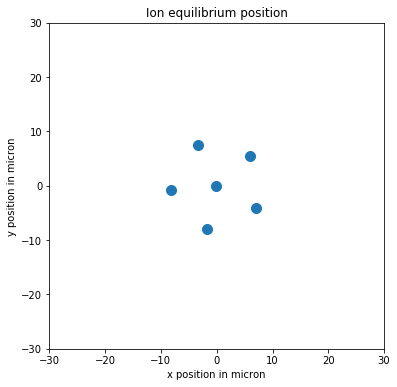

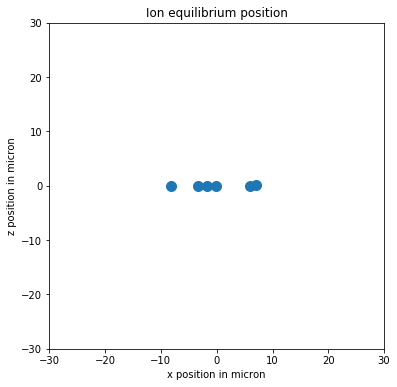

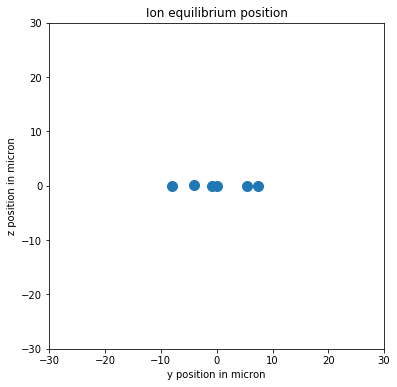

In [190]:
# Plot radial plane
xs = res.x[:N] * 1e6
ys = res.x[N:2*N] * 1e6
zs = res.x[2*N:3*N] * 1e6

plt.figure(figsize=(6,6))
plt.scatter(xs,ys, marker='o',s = 100)
plt.title('Ion equilibrium position')
plt.xlabel('x position in micron')
plt.ylabel('y position in micron')
plt.ylim(-30,30)
plt.xlim(-30,30)
plt.show()

plt.figure(figsize=(6,6))
plt.scatter(xs,zs, marker='o',s = 100)
plt.title('Ion equilibrium position')
plt.xlabel('x position in micron')
plt.ylabel('z position in micron')
plt.ylim(-30,30)
plt.xlim(-30,30)
plt.show()

plt.figure(figsize=(6,6))
plt.scatter(ys,zs, marker='o',s = 100)
plt.title('Ion equilibrium position')
plt.xlabel('y position in micron')
plt.ylabel('z position in micron')
plt.ylim(-30,30)
plt.xlim(-30,30)
plt.show()